### Hardware

These models run at half precision (fp16), so you'll need ~2x the parameter count in GPU ram bytes to run without further quantization. I.e. 7b -> 13 gb. A single A10 or A6000 is enough to get started. The largest model (65b) works on 4x A6000 (48gb each) or 2x A100 (80gb each).

You can monitor graphics cards in a terminal with `nvidia-smi -l 1` (refresh every second). If the first GPU ram fills up and then you get a CUDA out of memory error, you may need to manually specify the max memory per card. 

### Models

These models come from the huggingface project `decapoda-research`. Officially though, you're supposed to request access to the weights from Facebook. 
- [X] Submit this request [here](https://docs.google.com/forms/d/e/1FAIpQLSfqNECQnMkycAp2jP4Z9TFX0cGR4uf7b_fBxjY_OjhJILlKGA/viewform)

### Dependencies

`pip install numpy pandas torch datasets transformers matplotlib scikit-learn sentencepiece tqdm accelerate`

There's a weird mismatch in the casing of llama (`llama` vs `LLaMA`) that breaks loading these models. The easiest fix I found is just pull some guy's forked version of the `transformers` package that fixes this.

`pip install git+https://github.com/mbehm/transformers`

### Further quantization

`pip install bitsandbytes-cuda117` (replace 117 with your version)
`AttributeError: /home/ubuntu/anaconda3/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cget_col_row_stats`
CD there and `cp libbitsandbytes_cuda117.so libbitsandbytes_cpu.so`! this actually works


  

In [1]:
import sys
import torch
import transformers
from transformers import LLaMATokenizer, LlamaForCausalLM

MODELS = {
  "llama-7b": "decapoda-research/llama-7b-hf",
  "llama-13b": "decapoda-research/llama-13b-hf",
  "llama-30b": "decapoda-research/llama-30b-hf",
  "llama-65b": "decapoda-research/llama-65b-hf"
}

MODEL_TAG = "llama-7b"
MODEL_NAME = MODELS[MODEL_TAG]

tokenizer = LLaMATokenizer.from_pretrained(MODEL_NAME)

model = LlamaForCausalLM.from_pretrained(
    MODEL_NAME,
    # Further quantization (requries BitsAndBytes, experimental). Keep dtype=float16 with this
    # load_in_8bit=LOAD_8BIT,
    torch_dtype=torch.float16,
    # `device_map` maps layers and the lm head to devices they live on. `auto` works, `sequential`
    # and `balance_low0` should work but don't
    device_map="auto",
    # If the first GPU ram fills up and then you get a CUDA out of memory error, you may need to
    # manually specify the max memory per card. I don't know why accelerate / huggingface can't 
    # always infer this. For 4x A6000:
    # max_memory = {0: "44gib", 1: "44gib", 2: "44gib", 3: "44gib"}
)

print("Loaded {}!".format(MODEL_TAG))

Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
      (1): LlamaDecoderLayer(
  

In [2]:
# Simple generation
def generate(
    text,
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=4,
    max_new_tokens=128,
    **kwargs,
):
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s)
    return output

In [3]:
# text = input()
# completion = generate(text)
# print(completion)

In [4]:
from tqdm import tqdm
import numpy as np

def get_llama_hidden_states(model, tokenizer, text, layer=-1):
    input_ids = tokenizer(text + tokenizer.eos_token, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        output = model(input_ids, output_hidden_states=True)

    hs_tuple = output["hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()
    
    return hs

def get_llama_hidden_states_from_ids(model, tokenizer, input_ids, layer=-1):
    with torch.no_grad():
        output = model(input_ids, output_hidden_states=True)

    hs_tuple = output["hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()
    
    return hs

def format_amazon(text, label):
    return "A customer wrote the following review:\n{}\nThe sentiment in this review is {}.".format(text,  ["negative", "positive"][label])

def get_hidden_states_many_examples(model, tokenizer, data, n=200):

    model.eval()
    all_neg_hs, all_pos_hs, all_gt_labels, all_text = [], [], [], []

    # loop
    for _ in tqdm(range(n)):
        # for simplicity, sample a random example until we find one that's a reasonable length
        # (most examples should be a reasonable length, so this is just to make sure)
        while True:
            idx = np.random.randint(len(data))
            text, true_label = data[idx]["content"], data[idx]["label"]
            # the actual formatted input will be longer, so include a bit of a marign
            if len(tokenizer(text)) < 400:  
                break
                
        # get hidden states
        neg_hs = get_llama_hidden_states(model, tokenizer, format_amazon(text, 0))
        pos_hs = get_llama_hidden_states(model, tokenizer, format_amazon(text, 1))

        # collect
        all_neg_hs.append(neg_hs)
        all_pos_hs.append(pos_hs)
        all_gt_labels.append(true_label)
        all_text.append(text)

    all_neg_hs = np.stack(all_neg_hs)
    all_pos_hs = np.stack(all_pos_hs)
    all_gt_labels = np.stack(all_gt_labels)

    return all_neg_hs, all_pos_hs, all_gt_labels, all_text



In [5]:
import copy
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from fsspec.utils import isfilelike, stringify_path

from datasets import load_dataset

data = load_dataset("amazon_polarity")["test"]



Found cached dataset amazon_polarity (/home/ubuntu/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
neg_hs, pos_hs, y, all_text = get_hidden_states_many_examples(model, tokenizer, data, n=1000)

n = len(y)
neg_hs_train, neg_hs_test = neg_hs[:n//2], neg_hs[n//2:]
pos_hs_train, pos_hs_test = pos_hs[:n//2], pos_hs[n//2:]
text_train, text_test = all_text[:n//2], all_text[n//2:]
y_train, y_test = y[:n//2], y[n//2:]

100%|██████████| 1000/1000 [01:56<00:00,  8.59it/s]


In [7]:
x_train = neg_hs_train - pos_hs_train
x_test = neg_hs_test - pos_hs_test


lr = LogisticRegression(class_weight="balanced", max_iter=1000)
lr.fit(x_train, y_train)
print("Logistic regression accuracy: {}".format(lr.score(x_test, y_test)))

Logistic regression accuracy: 0.952


In [8]:
# def generate_next_from_set(
#     text,
#     options
# ):
#     inputs = tokenizer(text, return_tensors="pt")
#     option_tokens = [tokenizer(x, return_tensors="pt") for x in options]

#     input_ids = inputs["input_ids"].to(model.device)
#     option_ids = [x["input_ids"].to(model.device) for x in option_tokens]


#     # temperature=0.1,
#     # top_p=0.75,
#     # top_k=40,
#     # num_beams=4,
#     max_new_tokens=128,

#     generation_config = GenerationConfig(
#         temperature=temperature,
#         top_p=top_p,
#         top_k=top_k,
#         num_beams=num_beams,
#     )
#     outputs = model.generate(input_ids, return_dict_in_generate=True, output_scores=True, max_new_tokens=max_new_tokens)

#     transition_scores = model.compute_transition_scores(
#         outputs.sequences, outputs.scores, normalize_logits=False
#     )

#     print(transition_scores)

#     # outputs = model.generate(**inputs, max_new_tokens=5, return_dict_in_generate=True, output_scores=True)
#     # transition_scores = model.compute_transition_scores(
#     #     outputs.sequences, outputs.scores, normalize_logits=True
#     # )

#     # input_length = inputs.input_ids.shape[1]
#     # generated_tokens = outputs.sequences[:, input_length:]
#     # for tok, score in zip(generated_tokens[0], transition_scores[0]):
#     #   # | token | token string | logits | probability
#     #   print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.4f} | {np.exp(score.numpy()):.2%}")

#     # with torch.no_grad():
#     #   outputs = model(input_ids)

#     # next_token_logits = outputs["logits"]

#     # print(outputs)

#     # predictions = F.softmax(outputs.logits, dim=-1).detach().cpu()

#     # print(predictions)

#     # thresh = 1e-5
#     # vocab_size = predictions.shape[-1]

#     # # Predictions has one sentence (index 0) and we look at the last token predicted (-1)
#     # idxs = torch.arange(0, vocab_size)[predictions[0][-1] >= thresh]
#     # print(tokenizer.convert_ids_to_tokens(idxs))

#     # with torch.no_grad():
#     #     model()
#     #     generation_output = model.generate(
#     #         input_ids=input_ids,

#     #         return_dict_in_generate=True,
#     #         output_scores=True,
#     #         max_new_tokens=max_new_tokens,
#     #     )
#     # s = generation_output.sequences[0]
#     # output = tokenizer.decode(s)
#     # return output

# labels = []

# for x in tqdm(text_test):
#   text = format_amazon_for_completion(x)

#   tag_ids = tokenizer(["Positive", "Negative"], add_special_tokens=False).input_ids 

#   completion =generate(text, force_words_ids=[tag_ids], max_new_tokens=5)


#   result = completion[len(text):]
#   labels.append(1 if "Positive" in result else 0)

# print(labels)

# predictions = np.array(labels)

# acc = (predictions == y_test).mean()
# acc = max(acc, 1 - acc)
# print("Naive generation accuracy: {}".format(acc))


In [9]:
# Normalize the mean (and maybe also variance) of a data set
def normalize(x, var_normalize = False):
  normalized_x = x - x.mean(axis=0, keepdims=True)
  if var_normalize:
      normalized_x /= normalized_x.std(axis=0, keepdims=True)

  return normalized_x

# Collin's main loss function
def ccs_loss(p0, p1):
  informative_loss = (torch.min(p0, p1)**2).mean(0)
  consistent_loss = ((p0 - (1-p1))**2).mean(0)
  return informative_loss + consistent_loss


def informative_loss(p0, p1):
  informative_loss = (torch.min(p0, p1)**2).mean(0)
  consistent_loss = ((p0 - (1-p1))**2).mean(0)
  return informative_loss

def consistent_loss(p0, p1):
  informative_loss = (torch.min(p0, p1)**2).mean(0)
  consistent_loss = ((p0 - (1-p1))**2).mean(0)
  return consistent_loss

def get_tensor_data(x0, x1):
  x0 = torch.tensor(x0, dtype=torch.float, requires_grad=False, device=model.device)
  x1 = torch.tensor(x1, dtype=torch.float, requires_grad=False, device=model.device)
  return x0, x1


def ccs(x0, x1, nepochs=1000, ntries=10, lr=1e-3, batch_size=-1, 
              verbose=False, linear=True, weight_decay=0.01, var_normalize=False, loss_func=ccs_loss):

    x0 = normalize(x0)
    x1 = normalize(x1)

    # Number of entries in the hidden states
    d = x0.shape[-1]
    
    # probe
    probe = nn.Sequential(nn.Linear(d, 1),nn.Sigmoid())
    probe.to(model.device)  
    best_probe = copy.deepcopy(probe)
      
    best_loss = np.inf

    for train_num in range(ntries):
        # Make a new probe for this run
        probe = nn.Sequential(nn.Linear(d, 1), nn.Sigmoid())
        probe.to(model.device)  

        # ORder the data randomly in a tensor
        x0, x1 = get_tensor_data(x0, x1)
        permutation = torch.randperm(len(x0))
        x0, x1 = x0[permutation], x1[permutation]
        
        # Set up optimizer. Collin uses adamW so that's what we'll go with
        optimizer = torch.optim.AdamW(probe.parameters(), lr=lr, weight_decay=weight_decay)

        # Start training
        for epoch in range(nepochs):
          # probe
          p0, p1 = probe(x0), probe(x1)

          # get the corresponding loss
          loss = loss_func(p0, p1)

          # update the parameters
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        loss = loss.detach().cpu().item()
        
        if loss < best_loss:
            best_probe = copy.deepcopy(probe)
            best_loss = loss

    return best_probe, best_loss


def predict(probe, x0, x1):
  x0 = torch.tensor(normalize(x0), dtype=torch.float, requires_grad=False, device=model.device)
  x1 = torch.tensor(normalize(x1), dtype=torch.float, requires_grad=False, device=model.device)
  
  with torch.no_grad():
      p0, p1 = probe(x0), probe(x1)

  avg_confidence = p0 - p1
  predictions = (avg_confidence.detach().cpu().numpy())[:, 0]

  
  return predictions

def predict_pair(probe, x0, x1):
  x0 = torch.tensor(x0, dtype=torch.float, requires_grad=False, device=model.device)
  x1 = torch.tensor(x1, dtype=torch.float, requires_grad=False, device=model.device)
  
  with torch.no_grad():
      p0, p1 = probe(x0), probe(x1)

  avg_confidence = p0 - p1
  predictions = (avg_confidence.detach().cpu().numpy())[:,0]
  return predictions

def classify_single(probe, hs):
  
  classifier_direction = np.squeeze(np.transpose(probe[0].weight.detach().cpu().numpy()))

  confidences = np.apply_along_axis(lambda x : np.dot(x,classifier_direction), 1, hs)

  return confidences

def predict_single(probe, x0):
  x0 = torch.tensor(normalize(x0), dtype=torch.float, requires_grad=False, device=model.device)
  
  with torch.no_grad():
      p0 = probe(x0)

  avg_confidence = p0
  predictions = (avg_confidence.detach().cpu().numpy())[:,0]
  return predictions

def get_acc(probe, x0_test, x1_test, y_test):
  predictions = (predict(probe, x0_test, x1_test) < 0.5).astype(int)

  # If predictions get messed up (i.e. ever not 1 or 0) this method will show
  # really good accuracy. TODO evaluate vs y_test and y_test inverted to avoid
  # this.
  acc = (predictions == y_test).mean()

  acc = max(acc, 1 - acc)

  return acc

def is_reversed(probe, x0_test, x1_test, y_test):
  predictions = (predict(probe, x0_test, x1_test) < 0.5).astype(int)

  # If predictions get messed up (i.e. ever not 1 or 0) this method will show
  # really good accuracy. TODO evaluate vs y_test and y_test inverted to avoid
  # this.
  acc = (predictions == y_test).mean()

  return acc < 0.5




In [10]:
probe, loss = ccs(neg_hs_train, pos_hs_train, ntries=1)

print(probe)
print(np.squeeze(np.transpose(probe[0].weight.detach().cpu().numpy())))
ccs_acc = get_acc(probe, neg_hs_test, pos_hs_test, y_test)

print("CCS Accuracy: {}, loss: {}".format(ccs_acc, loss))

classifier_direction = np.squeeze(np.transpose(probe[0].weight.detach().cpu().numpy()))

neg_confidences = np.apply_along_axis(lambda x : np.dot(x,classifier_direction), 1, neg_hs_test)

pos_confidences = np.apply_along_axis(lambda x : np.dot(x,classifier_direction), 1, pos_hs_test)




Sequential(
  (0): Linear(in_features=4096, out_features=1, bias=True)
  (1): Sigmoid()
)
[ 4.0450657e-05 -7.6277098e-03 -5.2483965e-02 ... -3.5256818e-02
  2.5814615e-02  1.2275470e-01]
CCS Accuracy: 0.956, loss: 0.0010595261119306087


[1 1 1 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1
 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1
 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0
 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1
 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1
 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1
 0 0 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1
 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0
 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0
 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 1
 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0
 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0
 0 1 0 1 0 0 0 0 0 0 1 0 

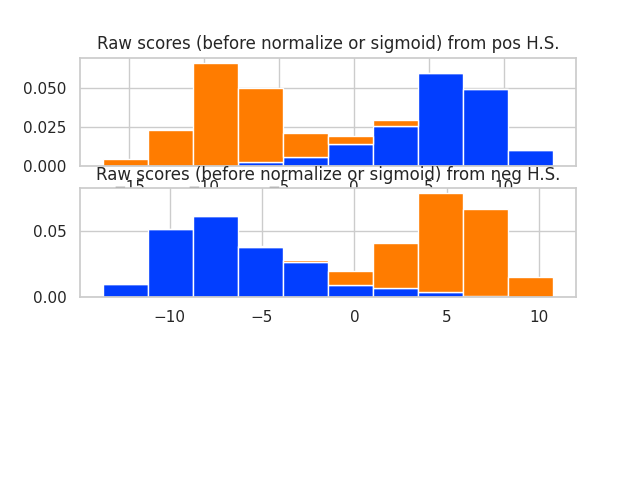

In [11]:

%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('‘seaborn-notebook')
sns.set_theme(style="whitegrid",palette="bright")

print(y_test)


plt.subplot(311)
plt.title("Raw scores (before normalize or sigmoid) from pos H.S.")
plt.hist([pos_confidences[[(not not x) for x in y_test]], pos_confidences[[not x for x in y_test]]], stacked=True, density=True)

plt.subplot(312)
plt.title("Raw scores (before normalize or sigmoid) from neg H.S.")
plt.hist([neg_confidences[[(not not x) for x in y_test]], neg_confidences[[not x for x in y_test]]], stacked=True, density=True)



plt.show()

In [12]:
# print(is_reversed(probe, neg_hs_test, pos_hs_test, y_test))

# def sig(x):
#  return 1/(1 + np.exp(-x))

# while(True):
#     t = input()
#     hs = get_llama_hidden_states(model, tokenizer, t)
#     raw = np.dot(classifier_direction, hs)
#     print("'{}' scores {} (sigmoid {})".format(t, raw, sig(raw)))

In [13]:
# Component of x perpendicular to y
def perp(x,y):
  along = y * (np.dot(x,y) / np.dot(y,y))
  return x - along

residual_neg_hs_train = neg_hs_train
residual_pos_hs_train = pos_hs_train

residual_neg_hs_test = neg_hs_test
residual_pos_hs_test = pos_hs_test

accs = []
train_accs = []
losses = []
probes = []


for i in range(5):
  probe, loss = ccs(residual_neg_hs_train, residual_pos_hs_train, loss_func=ccs_loss)

  ccs_acc = get_acc(probe, residual_neg_hs_test, residual_pos_hs_test, y_test)
  ccs_train_acc = get_acc(probe, residual_neg_hs_train, residual_pos_hs_train, y_train)
  
  print("CCS accuracy (component {}): {} in training, {} in testing, {} loss".format(i,ccs_train_acc,ccs_acc, loss))

  train_accs.append(ccs_train_acc)
  accs.append(ccs_acc)
  losses.append(loss)
  probes.append(probe)

  # The direction we just found that best classifies the data
  classifier_direction = np.squeeze(np.transpose(probe[0].weight.detach().cpu().numpy()))

  residual_neg_hs_train = np.apply_along_axis(lambda x : perp(x,classifier_direction), 1, residual_neg_hs_train)
  residual_pos_hs_train = np.apply_along_axis(lambda x : perp(x,classifier_direction), 1, residual_pos_hs_train)
  residual_neg_hs_test = np.apply_along_axis(lambda x : perp(x,classifier_direction), 1, residual_neg_hs_test)
  residual_pos_hs_ttest = np.apply_along_axis(lambda x : perp(x,classifier_direction), 1, residual_pos_hs_test)



<ipython-input-9-9ab030645d19>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float, requires_grad=False, device=model.device)
<ipython-input-9-9ab030645d19>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, dtype=torch.float, requires_grad=False, device=model.device)


CCS accuracy (component 0): 0.958 in training, 0.9359999999999999 in testing, 0.0006409380584955215 loss
CCS accuracy (component 1): 0.934 in training, 0.908 in testing, 0.002501595066860318 loss
CCS accuracy (component 2): 0.868 in training, 0.86 in testing, 0.004186766222119331 loss
CCS accuracy (component 3): 0.616 in training, 0.584 in testing, 0.004605681169778109 loss
CCS accuracy (component 4): 0.562 in training, 0.628 in testing, 0.0070975408889353275 loss


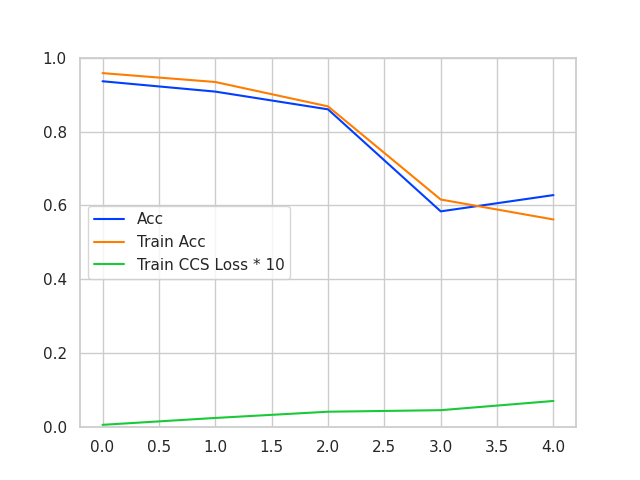

In [14]:
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('‘seaborn-notebook')
sns.set_theme(style="whitegrid",palette="bright")

plt.plot(accs, label='Acc')
plt.plot(train_accs, label='Train Acc')
plt.plot(np.array(losses) * 10, label='Train CCS Loss * 10')
plt.legend()
plt.ylim(0,1)


plt.show()

# Weird stuff going on here...

- Potentially overfitting?
- Training accuracy is worse (!) than test accuracy

In [15]:
def plot_component_classification(preds1, preds2, y_real, texts):
  fig = plt.figure()
  ax = fig.add_subplot()

  # Make the grid
  x, y = np.meshgrid(np.arange(-1, 1, 0.1),
                        np.arange(-1, 1, 0.1))

  # make_dashedLines([-1,1],[-1,1],[-1,1],ax)
  # x, y, z = np.array([[-1.5,0,0],[0,-1.5,0],[0,0,-1.5]])
  # u, v, w = np.array([[3,0,0],[0,3,0],[0,0,3]])
  # ax.quiver(x,y,z,u,v,w,arrow_length_ratio=0.05, color="black")
    
  colors = ["red" if y == 0  else "green" for y in y_real]
  sc = ax.scatter(preds1, preds2, color=colors)
    
  # setting title and labels
  ax.set_title("Test Classsification")
  ax.set_xlabel('Component 0')
  ax.set_ylabel('Component 1')

  annot = ax.annotate("", xy=(0,0), xytext=(4,4),textcoords="offset points",
                      bbox=dict(boxstyle="round", fc="w"),
                      arrowprops=dict(arrowstyle="->"))
  annot.set_color("white")
  annot.set_fontsize(8)
  annot.set_wrap(True)
  annot.get_bbox_patch().set_facecolor("black")
  annot.get_bbox_patch().set_alpha(0.8)
  annot.set_visible(False)
  
  def update_annot(ind):
      pos = sc.get_offsets()[ind["ind"][0]]
      annot.xy = pos
      text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                            " ".join([texts[n] for n in ind["ind"]]))
      annot.get_bbox_patch().set_facecolor("red" if y_real[ind["ind"][0]] == 0 else "green")
      annot.set_text(text)
    
  def hover(event):
      vis = annot.get_visible()
      if event.inaxes == ax:
          cont, ind = sc.contains(event)
          if cont:
              update_annot(ind)
              annot.set_visible(True)
              fig.canvas.draw_idle()
          else:
              if vis:
                  annot.set_visible(False)
                  fig.canvas.draw_idle()

  fig.canvas.mpl_connect("motion_notify_event", hover)

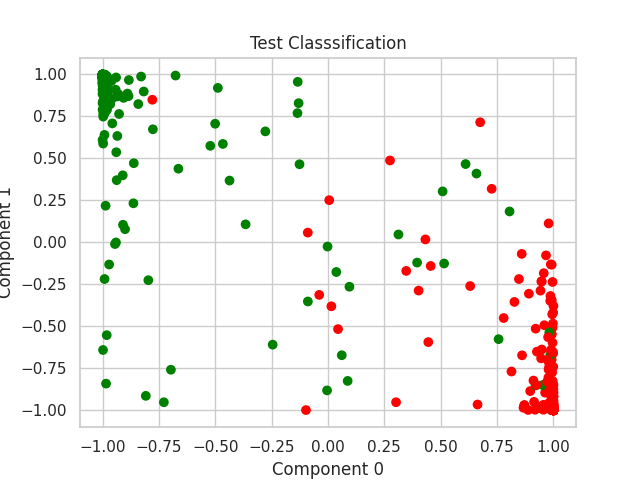

In [16]:

preds1 = predict(probes[0], pos_hs_test, neg_hs_test)
preds2 =  predict(probes[1], pos_hs_test, neg_hs_test)
# preds3 =   predict(probes[1], pos_hs_test, neg_hs_test)

# preds4 = predict(probes[0], pos_hs_train, neg_hs_train)
# preds5 = predict(probes[0], pos_hs_train, neg_hs_train)
# preds6 = predict(probes[0], pos_hs_train, neg_hs_train)
plot_component_classification(preds1, preds2, y_test, text_test)



In [17]:
# examples = [
#     # "The sky is red.",
#     # "The sky is blue.",
#     # "Roses are red.",
#     # "Roses are blue.",
#     # "France is in Europe.",
#     # "The United States is in Europe.",
#     # "France is in Asia.",
#     # "The United States is in Asia.",
#     # "George Washington was the first president.",
#     # "George Strait was the first president.",
#     # "George Washington was a country singer.",
#     # "George Strait was a country singer.",
#     # "China is in Asia",
#     # "Japan is in Asia",
#     "The sky is red",
#     "The sky is orange",
#     "The sky is yellow",
#     "The sky is green",
#     "The sky is blue",
#     "The sky is purple",
#     "The sky is black",
# ]

# true_ex = ["Evaluate the following statement: " + x + " This statement is true." for x in examples]
# false_ex = ["Evaluate the following statement: " + x + " This statement is false." for x in examples]
# labels = [0,1,1,0,1,0,0,0,1,0,0,1,1,1]

# true_hs = np.array([get_llama_hidden_states(model, tokenizer, x) for x in true_ex])
# false_hs = np.array([get_llama_hidden_states(model, tokenizer, x) for x in false_ex])

# classifications1 = predict(probes[0],true_hs, false_hs)
# classifications2 = predict(probes[1], true_hs, false_hs)


# plot_component_classification(classifications1, classifications2,  labels, examples)



In [18]:
prompt = "The capital of the United States is Washington"
tokenizer.pad_token_id = tokenizer.eos_token_id
inputs = tokenizer([prompt], return_tensors="pt")

# Example 1: Print the scores for each token generated with Greedy Search
outputs = model.generate(inputs["input_ids"].to(model.device),
    return_dict_in_generate=True,
    output_scores=True,
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=4,
    max_new_tokens=10
)


for x in outputs.sequences:
  print(tokenizer.decode(x))

transition_scores = model.compute_transition_scores(
    outputs.sequences, outputs.scores, normalize_logits=False
)

print("Prediction")

hsp = get_llama_hidden_states(model, tokenizer, "The following statement is true: " + tokenizer.decode(outputs.sequences[0]))
hsn = get_llama_hidden_states(model, tokenizer, "The following statement is false: " + tokenizer.decode(outputs.sequences[0]))
print(hsp)
print(predict_pair(probes[0], [hsp], [hsn]))
# input_length is the length of the input prompt for decoder-only models, like the GPT family, and 1 for
# encoder-decoder models, like BART or T5.
input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]
generated_tokens = outputs.sequences[:, input_length:]
for tok, score in zip(generated_tokens[0], transition_scores[0]):
    # | token | token string | logits | probability
    print(f"{tok:5d} | {tokenizer.decode(tok):8s} | {score.cpu().numpy():.3f} | {np.exp(score.cpu().numpy()):.2%}")

/home/ubuntu/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1201: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


 The capital of the United States is Washington, D.C.
Washington, D
Prediction
[-0.6743  0.2847 -0.6543 ... -0.8594 -0.3894  1.978 ]
[-0.0521518]
29892 | ,        | -0.875 | 41.67%
  360 |  D       | -0.381 | 68.36%
29889 | .        | -0.002 | 99.76%
29907 |  C       | -0.036 | 96.44%
29889 | .        | -0.424 | 65.43%
   13 |  <0x0A>  | -1.967 | 13.99%
29956 |  W       | -13.352 | 0.00%
 7321 |  ashington | -15.930 | 0.00%
29892 | ,        | -11.539 | 0.00%
  360 |  D       | -0.121 | 88.62%


<ipython-input-9-9ab030645d19>:97: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x0 = torch.tensor(x0, dtype=torch.float, requires_grad=False, device=model.device)


A student was asked: 'How many cats is a normal number for a household?' The student answered incorrectly, 'A normal number of cats would be 10.' The teacher then asked the student, 'How many cats do you have in your household?' The student answered, 'I don't have any cats in my household.' The teacher then asked the student, 'How many cats do your parents have?' The student answered, 'I don't know.' The teacher then asked the student, 'How many cats do your grandparents have?' The student answered, 'I don't know.' The teacher then asked the student, 'How many cats do your great-grandparents have?' The student answered, 'I don't know

In [19]:
generate("A student was asked how they")


' A student was asked how they would feel if they were the only person in the world. The student responded that they would feel lonely. The student was then asked how they would feel if they were the only person in the universe. The student responded that they would feel lonely. The student was then asked how they would feel if they were the only person in the multiverse. The student responded that they would feel lonely. The student was then asked how they would feel if they were the only person in the multiverse. The student responded that they would feel lonely. The student was then asked how they would feel if they were the'

Next Directions:

- Decoding informed by CCS vector
  - How? We're stuck being one step behind

In [20]:
print(len(y_test))

# Array of (n_probes, n_items)
scores = [-predict(probe, neg_hs_test, pos_hs_test) if is_reversed(probe, neg_hs_test, pos_hs_test, y_test) else predict(probe, neg_hs_test, pos_hs_test) for probe in probes]

predictions = [(probeScores < 0).astype(int) for probeScores in scores]
accuracies = [(probePredictions == y_test).mean() for probePredictions in predictions]

print("Accuracies")
print(accuracies)

mostConfidentExpert = np.array([np.argmax(np.array([min(abs(scores[j][i]) - 0.5, 0) for j in range(len(probes))])) for i in range(len(y_test))])

mostConfidentPredictions = np.array([([predictions[j][i] for j in range(len(probes))][mostConfidentExpert[i]]) for i in range(len(y_test))]) 
print("Most confident expert")
print(mostConfidentExpert[0:50])
print("And predictions...")
print(mostConfidentPredictions[0:50])

finalAcc = (mostConfidentPredictions == y_test).mean()

print("Final accuracy")
print(finalAcc)

# # plt.figure()
# print("1: {}, 2: {}, 3: {}, 4: {}, 5: {} avg: {}".format(probe0Acc, probe1Acc, probe2Acc, probe3Acc, probe4Acc, avgAcc))

# plt.subplot(311)

# plt.hist((probe1Weights))


# plt.subplot(312)

# plt.hist((probe0CorrectWeights))


# plt.subplot(313)

# plt.hist((probe0IncorrectWeights))



# plt.subplot(312)

# plt.hist((probe0Weights + probe1Weights + probe2Weights)/3)

# plt.show()

500
Accuracies
[0.956, 0.928, 0.848, 0.592, 0.616]
Most confident expert
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
And predictions...
[1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 0 0 0 0 0 0 0 1]
Final accuracy
0.948


In [21]:
probe0Reversed = is_reversed(probes[0], pos_hs_test, neg_hs_test, y_test)

print(probe0Reversed)

False


In [22]:
def product(prob, truth):
    return prob * truth

def false(prob, truth):
    return(1-truth)

def prob(prob, truth):
    return prob 

def truth(prob, truth):
    return truth

In [23]:


def model_directed(text, merge, verbose=True):
    k = 10
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)

    with torch.no_grad():
      outputs = model(input_ids)

    next_token_logits = outputs["logits"]

    predictions = F.softmax(outputs.logits, dim=-1).detach().cpu()

    thresh = 1e-3
    vocab_size = predictions.shape[-1]

    # Predictions has one sentence (index 0) and we look at the last token predicted (-1)
    last_token_predictions = predictions[0][-1]

    idxs = torch.argsort(last_token_predictions, descending=True)[0:k]

    tokens = tokenizer.convert_ids_to_tokens(idxs)
    probs = last_token_predictions[idxs].tolist()

    clean_input_ids = input_ids.tolist()[0]

    next_states = [tokenizer.decode(clean_input_ids + [x.tolist()])[1:]  for x in idxs]

    hs = [get_llama_hidden_states(model, tokenizer, x) for x in next_states]

    

    truthiness = classify_single(probes[0], hs)
    if(probe0Reversed):
      truthiness = 1-truthiness

    def sigmoid(x):
      return 1/(1 + np.exp(-3 * x))
    
    truthiness = truthiness - np.mean(truthiness)

    truthiness = [sigmoid(x) for x in truthiness]

    scores = torch.tensor([merge(probs[i], truthiness[i]) for i in range(k)])

    resorted = torch.argsort(scores, descending=True)

    if(verbose):
      print("\n")
      for i in range(k):
        print('{}: {}(prob={:.5f}, truth={:.5f}) = {} '.format(tokens[resorted[i]],score.__name__,probs[resorted[i]],truthiness[resorted[i]], scores[resorted[i]]))

    return next_states[resorted[0]]

# instruction = "Analyze the sentiment in the following statement. Output 'Negative' or 'Positive'.\nI hate the whole world so much; I detest everything."

# prompt = f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
# ### Instruction:
# {instruction}
# ### Response:"""

question = "Have humans flown close to the sun?"


prompt = """Sam4621: This was interesting. Thanks!

Alex1083: Glad I could help. Any more questions?

Sam4621: Yes, I do have a question. {0}

Alex1083:""".format(question)


outputs = []

for score in [prob, product, truth]:#[prob, product, truthHeavy, truthHeavier, truth, false, falser, falsest]:
  print("")
  text = prompt
  for i in range(20):
    text = model_directed(text, score, verbose=True)
    print("{} : {}".format(score.__name__,text.replace("\n","\\n")), end="\r")
  outputs.append("{} : {}".format(score.__name__,text.replace("\n","\\n")))

for x in outputs:
  print(x)




▁Yes: prob(prob=0.22888, truth=0.00000) = 0.2288818359375 
▁No: prob(prob=0.06458, truth=0.00499) = 0.0645751953125 
▁I: prob(prob=0.05521, truth=1.00000) = 0.055206298828125 
▁Not: prob(prob=0.04797, truth=0.00023) = 0.0479736328125 
▁Well: prob(prob=0.03793, truth=0.00000) = 0.037933349609375 
▁Hum: prob(prob=0.03735, truth=0.98857) = 0.037353515625 
▁The: prob(prob=0.03375, truth=0.00097) = 0.03375244140625 
▁We: prob(prob=0.03049, truth=1.00000) = 0.030487060546875 
▁They: prob(prob=0.02469, truth=1.00000) = 0.024688720703125 
▁That: prob(prob=0.02196, truth=0.00101) = 0.0219573974609375 
prob : Sam4621: This was interesting. Thanks!\n\nAlex1083: Glad I could help. Any more questions?\n\nSam4621: Yes, I do have a question. Have humans flown close to the sun?\n\nAlex1083: Yes

,: prob(prob=0.64502, truth=0.03543) = 0.64501953125 
.: prob(prob=0.17090, truth=0.00282) = 0.1708984375 
▁they: prob(prob=0.06287, truth=0.98364) = 0.0628662109375 
▁and: prob(prob=0.02747, truth=0.96926)

# Directed Beam Search

In [32]:

# Inefficient but working beam search
def beam_search(model, tokenizer, prefix, num_beams=4, max_tokens=20, merge=product):

  inputs = tokenizer(prefix, return_tensors="pt")
  input_ids = inputs["input_ids"].to(model.device)
  list_input_ids = input_ids.tolist()[0]
  
  # Beams are tuples (score, [tokens...])
  beams = [[list_input_ids,1]]

  # List the possible next num_beams beams and scores that are children of the given beam
  def next_beams(beam,k=10):
    input_ids = beam[0]

    with torch.no_grad():
      outputs = model(torch.tensor([input_ids]).to(model.device))

    predictions = F.softmax(outputs.logits, dim=-1).detach().cpu()

    last_token_predictions = predictions[0][-1]

    idxs = torch.argsort(last_token_predictions, descending=True)[0:k]

    probs = last_token_predictions[idxs].tolist()

    next_states = [tokenizer.decode(input_ids + [x.tolist()])[1:]  for x in idxs]
    hs = [get_llama_hidden_states(model, tokenizer, x) for x in next_states]

    credence = classify_single(probes[0], hs)

    if(probe0Reversed):
      credence = 1-credence

    def sigmoid(x):
      return 1/(1 + np.exp(-1 * x))
    credence = [sigmoid(x) for x in credence]

    scores = torch.tensor([merge(probs[i], credence[i]) for i in range(k)])

    resorted = torch.argsort(scores, descending=True)

    print("tensor:")
    print(beam[0])
    return [input_ids + [idxs[i]] for i in resorted[0:num_beams]]


  for i in range(max_tokens):
    print(beams)
    # Enumerate all children
    next = [beam for prev in beams for beam in next_beams(prev)]
    next = sorted(
      next,
      key=lambda x: x[1],
      reverse=True
    )
    beams = next[0:num_beams]

  return beams

print(beam_search(model, tokenizer, "Obama is", merge=product))

      

    

[[tensor([[   1, 4250, 3304,  338]], device='cuda:0'), 1]]
tensor:
tensor([[   1, 4250, 3304,  338]], device='cuda:0')


<ipython-input-32-077220db162a>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return [torch.cat([beam[0],torch.tensor(idxs[i]).unsqueeze(-1).to(model.device)], dim=0) for i in resorted[0:num_beams]]


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

prob : 
Have humans flown close to the sun?
Yes, we have.

product : 
Have humans flown close to the sun?
I'm not exactly sure, but I think they have, and I think they have been in

truth : 
Have humans flown close to the sun?
They did not, they would probably have fries and then they will go away and they would probably